# TF HUB 기본 예제

다음을 따라 한 것임
* https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%204%20-%20TensorFlow%20Serving/Week%202/Examples/tfhub_basic_examples.ipynb

내용
* hub.load() 기반 prediction
* hub.KerasLayer 기반 prediction
* hub.KerasLayer 기반 feature extraction
* local로 hub 파일 다운로드 후 사용 
* local_cache_dir 변경하기


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image


print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.3.0


## HUB.load 를 사용해서 모바일넷 기반 예측하기

--2021-04-05 21:34:45--  https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85624 (84K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>]  83.62K  --.-KB/s    in 0.007s  

2021-04-05 21:34:45 (11.8 MB/s) - ‘dog.jpeg’ saved [85624/85624]



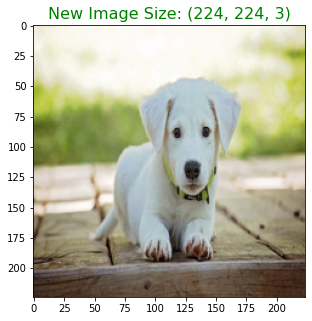

In [5]:
# get dog image
!wget -O dog.jpeg https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg

original_image = Image.open('./dog.jpeg')

# Format image 
IMAGE_SIZE = (224,224)
img = original_image.resize(IMAGE_SIZE)
img = np.array(img) / 255.0

# show
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title('New Image Size: {}'.format(img.shape), fontdict={'size': 16}, color='green')
plt.show()


In [6]:
# image label 준비
!wget -O labels.txt --quiet https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
    
with open('labels.txt') as f:
    labels = [l.strip() for l in f.readlines()]

num_classes = len(labels)

print('There are a total of {0} labels representing {0} classes.\n'.format(num_classes))

There are a total of 1001 labels representing 1001 classes.



In [9]:
# hub.load로 모듈 준비하기
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

# predict 수행
logits = module([img])
predictions = tf.nn.softmax(logits)[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)
top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}, {:.3}'.format(labels[i], value))

Labrador retriever, 0.426
Great Pyrenees, 0.0636
kuvasz, 0.0617
tennis ball, 0.0459
Old English sheepdog, 0.0287


## hub.KerasLayer() 기반 high level Keras API 사용하기

In [10]:
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE+(3,)),  # logits
    tf.keras.layers.Activation('softmax')
])

In [17]:
predictions = model.predict(np.expand_dims(img, axis=0))[0] # append batch dim and predict

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.426
Great Pyrenees: 0.0636
kuvasz: 0.0617
tennis ball: 0.0459
Old English sheepdog: 0.0287


## Feature vector로서 hub module 사용하기

In [18]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

NUM_CLASSES = 20

model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE,                    # as feature extractor
                  input_shape=IMAGE_SIZE +(3,)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

## Local Use를 위해서 TF HUB Module 저장하기

* download the Hub module by appending a query parameter to the module handled URL string

In [19]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed'

!wget -O ./saved_model.tar.gz $MODULE_HANDLE

--2021-04-05 21:52:04--  https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 216.58.196.238, 2404:6800:400a:806::200e
Connecting to tfhub.dev (tfhub.dev)|216.58.196.238|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz [following]
--2021-04-05 21:52:05--  https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.112, 34.64.4.80, 34.64.4.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13256595 (13M) [application/x-tar]
Saving to: ‘./saved_model.tar.gz’

./saved_model.tar.g 100%[===================>]  12.64M  7.14MB/s    in 1.8s    

2021-04-05 21:52:07 (7.14 MB/s) - ‘./

In [20]:
# decompress tarball
!mkdir -p ./saved_model
!tar xvzf ./saved_model.tar.gz -C ./saved_model

./
./assets/
./saved_model.pb
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001


In [22]:
## Running local tensorflow hub module

module = hub.load('./saved_model')

predictions = tf.nn.softmax(module([img]))[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.426
Great Pyrenees: 0.0636
kuvasz: 0.0617
tennis ball: 0.0459
Old English sheepdog: 0.0287


## Hub module 저장 위치 변경 

In [24]:
new_dir = './hub_cache_dir'
os.environ['TFHUB_CACHE_DIR'] = new_dir

In [25]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)


!ls -R {new_dir}

./hub_cache_dir:
426589ad685896ab7954855255a52db3442cb38d
426589ad685896ab7954855255a52db3442cb38d.descriptor.txt

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d:
assets	saved_model.pb	variables

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/assets:

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/variables:
variables.data-00000-of-00001  variables.index
